In [20]:
import os
import torch
from torch.utils.data import Dataset
import xarray as xr
import numpy as np
import rasterio
import torchvision.transforms as transforms
from datetime import datetime
import matplotlib.pyplot as plt

In [21]:
class MultiModalDataset(Dataset):
    def __init__(self, sentinel1_dir, sentinel2_dir, modis_dir, crop_dir, soil_dir, weather_dir, transform=None):
        """
        Initialize the dataset using Sentinel-1 folder dates (YYYY-MM-DD) and random 16x16 patches
        from a 1 mile x 1 mile area in WGS84 degrees.

        Args:
            sentinel1_dir (str): Directory for Sentinel-1 data (YYYY-MM-DD/vv.tif, vh.tif).
            sentinel2_dir (str): Directory for Sentinel-2 data (YYYY-MM-DD/B01.tif, etc.).
            modis_dir (str): Directory for MODIS data (YYYY-MM-DD/Band1.tif, etc.).
            crop_dir (str): Directory containing crop data NetCDF files (IA_year.nc).
            soil_file (str): Path to the soil NetCDF file (e.g., IA.nc) with variables 'nccpi3all', etc.
            weather_dir (str): Directory containing weather data NetCDF files (IA_year.nc).
            transform (callable, optional): Optional transform to apply to the data.
        """
        self.sentinel1_dir = sentinel1_dir
        self.sentinel2_dir = sentinel2_dir
        self.modis_dir = modis_dir
        self.cdl_dir = crop_dir
        self.soil_dir = soil_dir
        self.weather_dir = weather_dir
        self.transform = transform
        self.patch_size = 16  # 16x16 patch size
        self.mile_in_deg_lat = 0.01446  # 1 mile in latitude degrees (approx.)
        self.mile_in_deg_lon = 0.01947  # 1 mile in longitude degrees at 42°N (approx.)

        # Get week_start_dates from Sentinel-1 folder, filter for April to September
        self.week_start_dates = [
            d for d in os.listdir(sentinel1_dir)
            if os.path.isdir(os.path.join(sentinel1_dir, d)) and self._is_in_april_to_september(d)
        ]
        if not self.week_start_dates:
            raise ValueError("No Sentinel-1 data found for April to September.")

        # Load crop and weather datasets per year
        self.weather_ds = {}
        unique_years = set(date.split('-')[0] for date in self.week_start_dates)
        for year in unique_years:
            weather_file = os.path.join(weather_dir, f'IA_{year}.nc')
            self.weather_ds[year] = xr.open_dataset(weather_file)

        # Define all bands/variables
        self.s1_bands = ['vv', 'vh']  # 2 bands
        self.s2_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']  # 12 bands + 'B10' which is missing sometimes.
        self.modis_bands = ['Band1', 'Band2', 'Band3', 'Band4', 'Band5', 'Band6', 'Band7']  # 7 bands
        self.weather_vars = ['dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']  # 7 variables
        self.cdl_bands = ['Band_1']  # Crop Data Layer: 120 classes representing land cover uses including different crops like 'Maize', 'Soy', etc.
        self.soil_bands = ['nccpi3all', 'nccpi3corn', 'rootznaws', 'soc0_150', 'soc0_999', 'pctearthmc']  # 6 variables

        # Get spatial bounds from a sample Sentinel-1 GeoTIFF
        sample_s1_path = os.path.join(sentinel1_dir, self.week_start_dates[0], '4326_vv.tif')
        with rasterio.open(sample_s1_path) as src:
            self.bounds = src.bounds  # (left, bottom, right, top) in degrees
            self.transform_geo = src.transform  # Geotransform to convert degrees to pixels
            self.width, self.height = src.width, src.height

    def _is_in_april_to_september(self, date_str):
        """Check if date_str (YYYY-MM-DD) is between April 1st and September 30th."""
        try:
            date = datetime.strptime(date_str, '%Y-%m-%d')
            month = date.month
            day = date.day
            return (month == 4 and day >= 1) or (4 < month < 9) or (month == 9 and day <= 30)
        except ValueError:
            return False

    def _random_patch_coords(self):
        """Generate random top-left coordinates for a 1 mile x 1 mile area in degrees, then extract 16x16 patch."""
        # Random center in degrees within bounds (leaving room for 1 mile extent)
        lon_min = self.bounds.left + self.mile_in_deg_lon / 2
        lon_max = self.bounds.right - self.mile_in_deg_lon / 2
        lat_min = self.bounds.bottom + self.mile_in_deg_lat / 2
        lat_max = self.bounds.top - self.mile_in_deg_lat / 2
        
        lon_center = np.random.uniform(lon_min, lon_max)
        lat_center = np.random.uniform(lat_min, lat_max)

        # Define 1 mile x 1 mile area in degrees
        lon_start = lon_center - self.mile_in_deg_lon / 2
        lon_end = lon_center + self.mile_in_deg_lon / 2
        lat_start = lat_center - self.mile_in_deg_lat / 2
        lat_end = lat_center + self.mile_in_deg_lat / 2

        # Convert degree bounds to pixel coordinates
        x_start, y_end = rasterio.transform.rowcol(self.transform_geo, lon_start, lat_start)  # top-left
        x_end, y_start = rasterio.transform.rowcol(self.transform_geo, lon_end, lat_end)  # bottom-right

        # Adjust to ensure valid pixel bounds
        x_start = max(0, min(x_start, self.width - self.patch_size))
        y_start = max(0, min(y_start, self.height - self.patch_size))
        x_end = x_start + self.patch_size
        y_end = y_start + self.patch_size

        return x_start, y_start, x_end, y_end, lon_start, lat_start, lon_end, lat_end

    def __len__(self):
        return len(self.week_start_dates)

    def __getitem__(self, idx):
        week_start_date = self.week_start_dates[idx]
        year = week_start_date.split('-')[0]
        x_start, y_start, x_end, y_end, lon_start, lat_start, lon_end, lat_end = self._random_patch_coords()

        # 1. Sentinel-1 (all bands: vv, vh)
        s1_folder = os.path.join(self.sentinel1_dir, week_start_date)
        s1_patches = []
        for band in self.s1_bands:
            band_path = os.path.join(s1_folder, f'4326_{band}.tif')
            with rasterio.open(band_path) as src:
                band_patch = src.read(1)[y_start:y_end, x_start:x_end]
            s1_patches.append(torch.from_numpy(band_patch).float())
        s1_tensor = torch.stack(s1_patches, dim=0)  # (2, 16, 16)

        # 2. Sentinel-2 (all bands)
        s2_folder = os.path.join(self.sentinel2_dir, week_start_date)
        s2_patches = []
        for band in self.s2_bands:
            band_path = os.path.join(s2_folder, f'4326_{band}.tif')
            with rasterio.open(band_path) as src:
                band_patch = src.read(1)[y_start:y_end, x_start:x_end]
            s2_patches.append(torch.from_numpy(band_patch).float())
        s2_tensor = torch.stack(s2_patches, dim=0)  # (13, 16, 16)

        # 3. MODIS (all bands)
        modis_folder = os.path.join(self.modis_dir, week_start_date)
        modis_patches = []
        for band in self.modis_bands:
            band_path = os.path.join(modis_folder, f'4326_{band}.tif')
            with rasterio.open(band_path) as src:
                band_patch = src.read(1)[y_start:y_end, x_start:x_end]
            modis_patches.append(torch.from_numpy(band_patch).float())
        modis_tensor = torch.stack(modis_patches, dim=0)  # (7, 16, 16)
        
        # 4. CropData Layer (Band_1)
        cdl_patches = []
        for band in self.cdl_bands:
            band_path = os.path.join(self.cdl_dir, f'{year}_WGS84.tif')
            with rasterio.open(band_path) as src:
                band_patch = src.read(1)[y_start:y_end, x_start:x_end]
            cdl_patches.append(torch.from_numpy(band_patch).float())
        cdl_tensor = torch.stack(cdl_patches, dim=0)  # (2, 16, 16)

        # 4. soil data (all bands)
        soil_patches = []
        for band in self.soil_bands:
            band_path = os.path.join(self.soil_dir, f'merged_max_{band}_resampled.tif')
            with rasterio.open(band_path) as src:
                band_patch = src.read(1)[y_start:y_end, x_start:x_end]
            soil_patches.append(torch.from_numpy(band_patch).float())
        soil_tensor = torch.stack(soil_patches, dim=0)  # (2, 16, 16)

        # Convert degree bounds to NetCDF coordinates (assuming WGS84 alignment)
        weather_ds = self.weather_ds[year]
        weather_x = weather_ds['x'].values
        weather_y = weather_ds['y'].values
        nc_x_start = np.searchsorted(weather_x, lon_start, side='left')
        nc_x_end = np.searchsorted(weather_x, lon_end, side='right')
        nc_y_start = np.searchsorted(weather_y, lat_start, side='left')
        nc_y_end = np.searchsorted(weather_y, lat_end, side='right')

        # Adjust to 16x16 patch size for NetCDF
        if nc_x_end - nc_x_start > self.patch_size:
            nc_x_end = nc_x_start + self.patch_size
        if nc_y_end - nc_y_start > self.patch_size:
            nc_y_end = nc_y_start + self.patch_size

       

        # 5. Soil Data (all variables: nccpi3all, nccpi3corn, rootznaws, soc150, soc999, pctearthmc)
        # soil_patches = []
        # for var in self.soil_vars:
        #     patch = self.soil_ds[var].isel(x=slice(nc_x_start, nc_x_end), y=slice(nc_y_start, nc_y_end)).values
        #     soil_patches.append(torch.from_numpy(patch).float())
        # soil_tensor = torch.stack(soil_patches, dim=0)  # (6, 16, 16)

        # 6. Weather Data (all variables: dayl, prcp, srad, swe, tmax, tmin, vp)
        time_idx = np.where(weather_ds['time'].values == np.datetime64(week_start_date))[0][0]
        weather_patches = []
        for var in self.weather_vars:
            patch = weather_ds[var].isel(time=time_idx, x=slice(nc_x_start, nc_x_end), y=slice(nc_y_start, nc_y_end)).values
            weather_patches.append(torch.from_numpy(patch).float())
        weather_tensor = torch.stack(weather_patches, dim=0)  # (7, 16, 16)

        # Stack modalities into a list (variable channels per modality)
        modalities = [s1_tensor, s2_tensor, modis_tensor, cdl_tensor, soil_tensor, weather_tensor]
        # Shapes: [(2, 16, 16), (13, 16, 16), (7, 16, 16), (N_crop, 16, 16), (6, 16, 16), (7, 16, 16)]

        if self.transform:
            modalities = [self.transform(m) for m in modalities]

        # Dummy label (replace with actual labels if available)
        label = 0

        return modalities, label

In [22]:
def display_sample(dataset, sample_idx=0):
    modalities, label = dataset[sample_idx]
    modality_names = ['Sentinel-1', 'Sentinel-2', 'MODIS', 'Crop', 'Soil', 'Weather']
    
    def normalize_channel(channel, percentile=2):
        vmin = np.percentile(channel, percentile)
        vmax = np.percentile(channel, 100 - percentile)
        channel = (channel - vmin) / (vmax - vmin)
        channel = np.clip(channel, 0, 1)
        return channel
    
    fig, axes = plt.subplots(1, len(modalities), figsize=(20, 4))
    
    for i, (modality, name) in enumerate(zip(modalities, modality_names)):
        if name == 'Crop':
            # Display segmentation map with color for each class
            label_map = modality[0].numpy()  # (16, 16)
            unique_labels = np.unique(label_map)
            num_classes = len(unique_labels)
            cmap = plt.get_cmap('tab20', num_classes)  # Use tab20 for up to 20 classes
            im = axes[i].imshow(label_map, cmap=cmap, interpolation='nearest')
            cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.05)
            cbar.set_label('Class Label')
        elif name == 'Sentinel-2':
            # RGB composite: B04 (red, index 3), B03 (green, index 2), B02 (blue, index 1)
            r = normalize_channel(modality[3].numpy())
            g = normalize_channel(modality[2].numpy())
            b = normalize_channel(modality[1].numpy())
            rgb = np.stack([r, g, b], axis=-1)
            axes[i].imshow(rgb)
        elif name == 'MODIS':
            # RGB composite: Band1 (red, index 0), Band4 (green, index 3), Band3 (blue, index 2)
            r = normalize_channel(modality[0].numpy())
            g = normalize_channel(modality[3].numpy())
            b = normalize_channel(modality[2].numpy())
            rgb = np.stack([r, g, b], axis=-1)
            axes[i].imshow(rgb)
        else:
            # Grayscale for other modalities, using first channel
            channel = normalize_channel(modality[0].numpy())
            axes[i].imshow(channel, cmap='gray')
        axes[i].set_title(name)
        axes[i].axis('off')
    
    plt.show()

/scratch/aapowadi/6227678/ipykernel_3491765/4287091849.py:8: RuntimeWarning: invalid value encountered in divide
  channel = (channel - vmin) / (vmax - vmin)


IndexError: index -1 is out of bounds for axis 0 with size 0

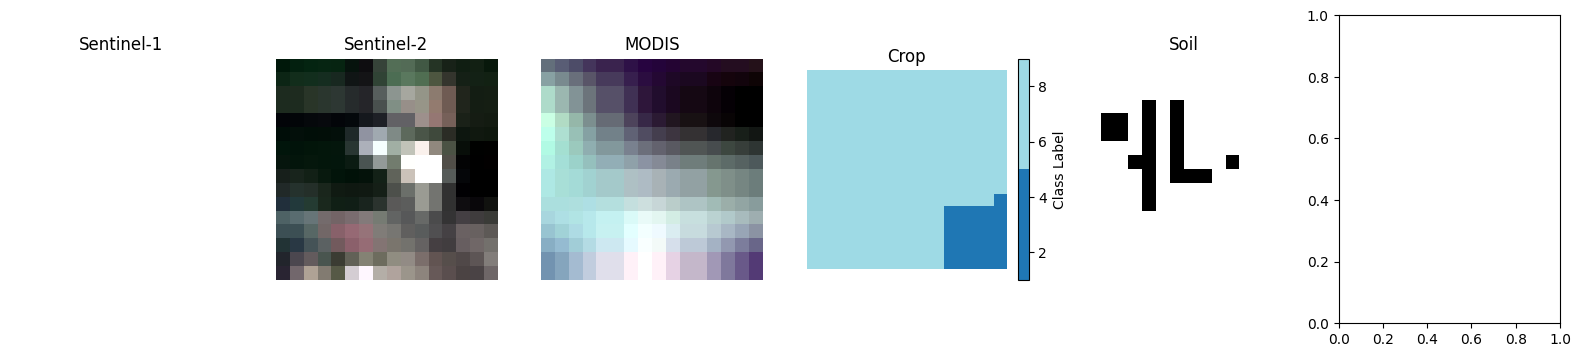

In [23]:
# Example usage:
dataset = MultiModalDataset(
    sentinel1_dir='/work/mech-ai-scratch/rtali/gis-sentinel1/final_s1',
    sentinel2_dir='/work/mech-ai-scratch/rtali/gis-sentinel2/final_s2_v3',
    modis_dir='/work/mech-ai-scratch/rtali/gis-modis/modis',
    crop_dir='/work/mech-ai-scratch/rtali/gis-CDL/final_CDL',
    soil_dir='/work/mech-ai-scratch/rtali/AI_READY_IOWA/SOIL',
    weather_dir='/work/mech-ai-scratch/rtali/AI_READY_IOWA/WEATHER',
    transform=transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust mean/std per channel if needed
)

# Get channel counts
num_channels_list = [
    len(dataset.s1_bands),      # 2 (Sentinel-1)
    len(dataset.s2_bands),      # 13 (Sentinel-2)
    len(dataset.modis_bands),   # 7 (MODIS)
    len(dataset.cdl_bands),     # Update with actual count
    len(dataset.soil_bands),     # 6 (Soil)
    len(dataset.weather_vars)   # 7 (Weather)
]
display_sample(dataset)

In [24]:
sample = dataset[0][0]

In [26]:
sample[5].shape

torch.Size([7, 0, 2])

In [ ]:
label_map = modality[0].numpy()  # (16, 16)
unique_labels = np.unique(label_map)
num_classes = len(unique_labels)
cmap = plt.get_cmap('tab20', num_classes)  # Use tab20 for up to 20 classes
im = axes[i].imshow(label_map, cmap=cmap, interpolation='nearest')
cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.05)
cbar.set_label('Class Label')

In [9]:
crop_dir='/work/mech-ai-scratch/rtali/AI_READY_IOWA/CDL/IN4326'
crop_file = os.path.join(crop_dir, f'IA_2023.nc')
crop_data = xr.open_dataset(crop_file)
crop_data

<xarray.Dataset> Size: 2GB
Dimensions:                        (band: 1, x: 19546, y: 10113)
Coordinates:
  * band                           (band) int64 8B 1
  * x                              (x) float64 156kB -96.67 -96.67 ... -90.14
  * y                              (y) float64 81kB 43.63 43.63 ... 40.25 40.25
Data variables:
    spatial_ref                    int64 8B ...
    __xarray_dataarray_variable__  (band, y, x) float64 2GB ...

In [10]:
crop_data.isel(band=0)

<xarray.Dataset> Size: 2GB
Dimensions:                        (x: 19546, y: 10113)
Coordinates:
    band                           int64 8B 1
  * x                              (x) float64 156kB -96.67 -96.67 ... -90.14
  * y                              (y) float64 81kB 43.63 43.63 ... 40.25 40.25
Data variables:
    spatial_ref                    int64 8B ...
    __xarray_dataarray_variable__  (y, x) float64 2GB ...